## Coursera Recommendation System using K-Means

Dataset: https://www.kaggle.com/datasets/khusheekapoor/coursera-courses-dataset-2021

In [ ]:
# Import libraries

import pandas as pd
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install kneed
from sklearn.cluster import KMeans
from kneed import KneeLocator
from IPython.display import clear_output

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import data

raw_data = pd.read_csv(r'Coursera.csv')

In [ ]:
raw_data.head()

,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [ ]:
raw_data.shape

(3522, 7)

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   University          3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB


In [ ]:
raw_data.isnull().sum() # no missing values

,0
Course Name,0
University,0
Difficulty Level,0
Course Rating,0
Course URL,0
Course Description,0
Skills,0


In [ ]:
# important attributes: name, difficulty level, description, skills

data = raw_data[['Course Name','Difficulty Level','Course Description','Skills']]
data.head()

,Course Name,Difficulty Level,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Beginner,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Beginner,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,Advanced,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,Intermediate,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Beginner,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [ ]:
# data preprocessing: tokenizing & removing stopwords, punctuation, and numbers

eng_stopwords = stopwords.words('english')
punctuations = string.punctuation

def preprocess(text):
  sentence = sent_tokenize(text)

  clean_tokens = []

  for s in sentence:
    words = word_tokenize(s)

    for w in words:
      if((w.lower() not in eng_stopwords) and (w not in punctuations) and w.isalpha()):
        clean_tokens.append(w.lower())

  clean_text = ' '.join(clean_tokens)  # Gabungkan token dengan spasi
  return clean_text

In [ ]:
# Generate keywords by combining words in columns: Course Name, Difficulty Level, Course Description, Skills
data['Keywords'] = data['Course Name'].apply(preprocess) + " " + data['Difficulty Level'].apply(preprocess) + " " + data['Course Description'].apply(preprocess) + " " + data['Skills'].apply(preprocess)

data.head()

<ipython-input-9-0f6203b133c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Keywords'] = data['Course Name'].apply(preprocess) + " " + data['Difficulty Level'].apply(preprocess) + " " + data['Course Description'].apply(preprocess) + " " + data['Skills'].apply(preprocess)


,Course Name,Difficulty Level,Course Description,Skills,Keywords
0,Write A Feature Length Screenplay For Film Or ...,Beginner,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...,write feature length screenplay film televisio...
1,Business Strategy: Business Model Canvas Analy...,Beginner,"By the end of this guided project, you will be...",Finance business plan persona (user experien...,business strategy business model canvas analys...
2,Silicon Thin Film Solar Cells,Advanced,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...,silicon thin film solar cells advanced course ...
3,Finance for Managers,Intermediate,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...,finance managers intermediate comes numbers al...
4,Retrieve Data using Single-Table SQL Queries,Beginner,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...,retrieve data using sql queries beginner cours...


In [ ]:
# Define final data

main_data = data[['Course Name','Keywords']]

main_data.head()

,Course Name,Keywords
0,Write A Feature Length Screenplay For Film Or ...,write feature length screenplay film televisio...
1,Business Strategy: Business Model Canvas Analy...,business strategy business model canvas analys...
2,Silicon Thin Film Solar Cells,silicon thin film solar cells advanced course ...
3,Finance for Managers,finance managers intermediate comes numbers al...
4,Retrieve Data using Single-Table SQL Queries,retrieve data using sql queries beginner cours...


In [ ]:
main_data.shape

(3522, 2)

In [ ]:
# text vectorization

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(main_data['Keywords'])
tfidf_matrix

<3522x19233 sparse matrix of type '<class 'numpy.float64'>'
	with 292745 stored elements in Compressed Sparse Row format>

In [ ]:
# modelling

kmeans_params = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}
sse = []
n_k = range(1, 101)

# find best k using elbow method
for k in n_k:
    print(f'Cluster {k}')
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)
    clear_output(wait=True)
locator = KneeLocator(n_k, sse, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator.elbow)

Best cluster for KMeans: 35


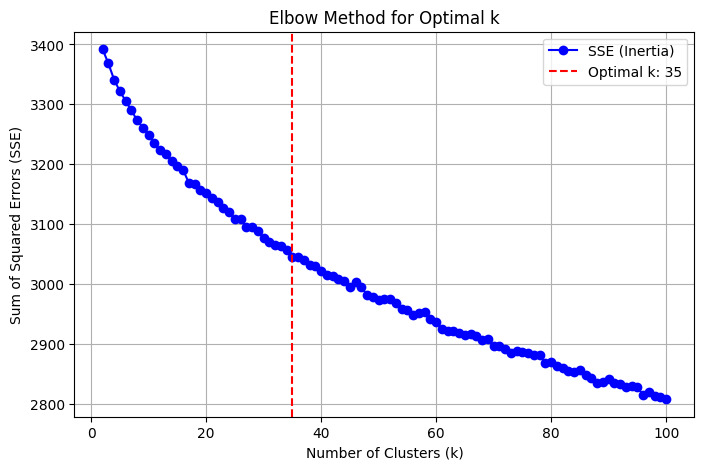

In [ ]:
# plotting
plt.figure(figsize=(8, 5))
plt.plot(n_k, sse, 'bo-', label='SSE (Inertia)')
plt.axvline(x=locator.elbow, color='r', linestyle='--', label=f'Optimal k: {locator.elbow}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# final model
kmeans = KMeans(n_clusters=locator.elbow, **kmeans_params)
kmeans.fit(tfidf_matrix)

# Set cluster for each data
main_data['Cluster'] = kmeans.labels_
main_data.head()

<ipython-input-68-7ed82024bd65>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_data['Cluster'] = kmeans.labels_


,Course Name,Keywords,Cluster
0,Write A Feature Length Screenplay For Film Or ...,write feature length screenplay film televisio...,10
1,Business Strategy: Business Model Canvas Analy...,business strategy business model canvas analys...,6
2,Silicon Thin Film Solar Cells,silicon thin film solar cells advanced course ...,32
3,Finance for Managers,finance managers intermediate comes numbers al...,19
4,Retrieve Data using Single-Table SQL Queries,retrieve data using sql queries beginner cours...,18


In [ ]:
# check for cluster 19 members -> turns out they have similar topic: finance

cluster_19 = main_data.loc[main_data['Cluster'] == 19, :]
cluster_19.head()

,Course Name,Keywords,Cluster
3,Finance for Managers,finance managers intermediate comes numbers al...,19
116,FinTech Foundations and Overview,fintech foundations overview intermediate prim...,19
120,"Risk, Return & Valuation",risk return valuation beginner course introduc...,19
123,Entrepreneurship II: Preparing for Launch,entrepreneurship ii preparing launch advanced ...,19
179,Portfolio Optimization using Markowitz Model,portfolio optimization using markowitz model b...,19


In [ ]:
# recommendation function
def recommend_course(query, top_n=10):

    # Transform user query into vector representation
    query_vec = tfidf_vectorizer.transform([query])

    # Compute similarity scores with all courses
    sim_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get top_n courses based on similarity scores
    top_indices = sim_scores.argsort()[::-1][:top_n]

     # Create a DataFrame to store the results
    recommendations = pd.DataFrame({
        'Course Name': raw_data.iloc[top_indices]['Course Name'].values,
        'University': raw_data.iloc[top_indices]['University'].values,
        'Difficulty Level': raw_data.iloc[top_indices]['Difficulty Level'].values,
        'Skills': raw_data.iloc[top_indices]['Skills'].values,
        'Course URL': raw_data.iloc[top_indices]['Course URL'].values,
        'Cluster': main_data.iloc[top_indices]['Cluster'].values,  # Cluster
        'Similarity Score': sim_scores[top_indices]  # Similarity score
    })

    # Format the similarity score to 3 decimal places
    recommendations['Similarity Score'] = recommendations['Similarity Score'].round(3)

    return recommendations

In [ ]:
recommendations = recommend_course("python")

recommendations

,Course Name,University,Difficulty Level,Skills,Course URL,Cluster,Similarity Score
0,Python Data Analysis,Rice University,Advanced,Data Visualization jpeg dict Python Program...,https://www.coursera.org/learn/python-analysis,2,0.700
1,Python Data Representations,Rice University,Advanced,immutable object Python Programming Smoothin...,https://www.coursera.org/learn/python-represen...,2,0.687
2,Python Programming Essentials,Rice University,Beginner,semantics Python Programming coding conventi...,https://www.coursera.org/learn/python-programming,2,0.643
3,"Python Functions, Files, and Dictionaries",University of Michigan,Conversant,jpeg computer program data file analysis P...,https://www.coursera.org/learn/python-function...,2,0.513
4,Python for Data Science and AI,IBM,Conversant,Python Programming python libraries analysis...,https://www.coursera.org/learn/python-for-appl...,2,0.508
5,Python for Data Science and AI,IBM,Conversant,Python Programming python libraries analysis...,https://www.coursera.org/learn/python-for-appl...,2,0.508
6,Python for Data Science and AI,IBM,Conversant,Python Programming python libraries analysis...,https://www.coursera.org/learn/python-for-appl...,2,0.508
7,Python for Data Science and AI,IBM,Conversant,Python Programming python libraries analysis...,https://www.coursera.org/learn/python-for-appl...,2,0.508
8,Python Basics,University of Michigan,Beginner,Problem Solving python syntax and semantics ...,https://www.coursera.org/learn/python-basics,2,0.502
9,Data Collection and Processing with Python,University of Michigan,Conversant,list comprehension representational state tra...,https://www.coursera.org/learn/data-collection...,2,0.497


Model K Means yang telah dibuat dapat dikatakan cukup baik dan akurat karena semua hasil rekomendasi di atas berasal dari cluster yang sama yaitu cluster 2.

In [ ]:
# Evaluation

from sklearn.metrics import silhouette_score, davies_bouldin_score

tfidf_dense = tfidf_matrix.toarray()

# Silhouette Score
sil_score = silhouette_score(tfidf_matrix, kmeans.labels_)
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index
db_score = davies_bouldin_score(tfidf_dense, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Silhouette Score: 0.0320
Davies-Bouldin Index: 5.2591


Silhouette Score: 0.0320 -> Skor mendekati 0 berarti cluster tumpang tindih dan tidak terbentuk dengan baik.

Davies-Bouldin Index: 5.2591 -> Nilai > 3 menunjukkan cluster terlalu mirip dan kurang terpisah dengan baik.